In [1]:
import numpy as np
import matplotlib.pyplot as plt

from ssp_bayes_opt import sspspace

# Make a non-stationary function

Make a function with a large flat region and a sharp region.

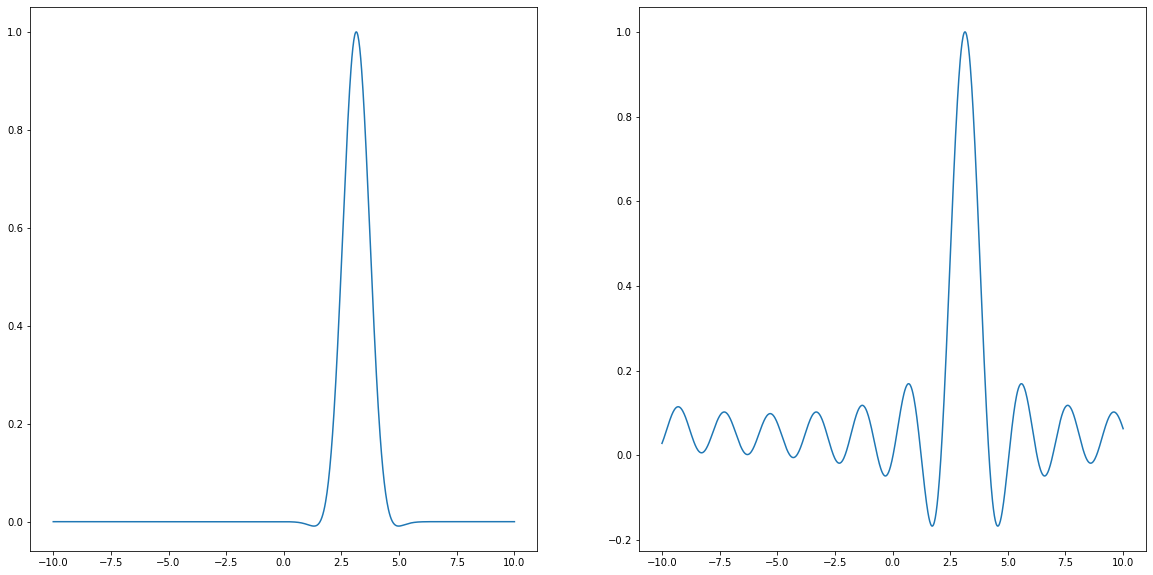

In [15]:
def easom_1d(xs):
    return -np.cos(xs) * np.exp(-(xs-np.pi)**2)

xs = np.linspace(-10,10,1000)

ssp_space = sspspace.HexagonalSSPSpace(domain_dim=1, ssp_dim=151, domain_bounds=np.array([[-10,10]]), length_scale=1)
ssp_xs = ssp_space.encode(np.atleast_2d(xs).T)

ssp_pi = ssp_space.encode(np.array([[np.pi]]))

sims = np.einsum('nd,sd->ns', ssp_xs, ssp_pi)

plt.figure(figsize=(20,10))
plt.subplot(1,2,1)
plt.plot(xs, easom_1d(xs))

plt.subplot(1,2,2)
plt.plot(xs, sims)


# Similarity as we block out different parts of the vector

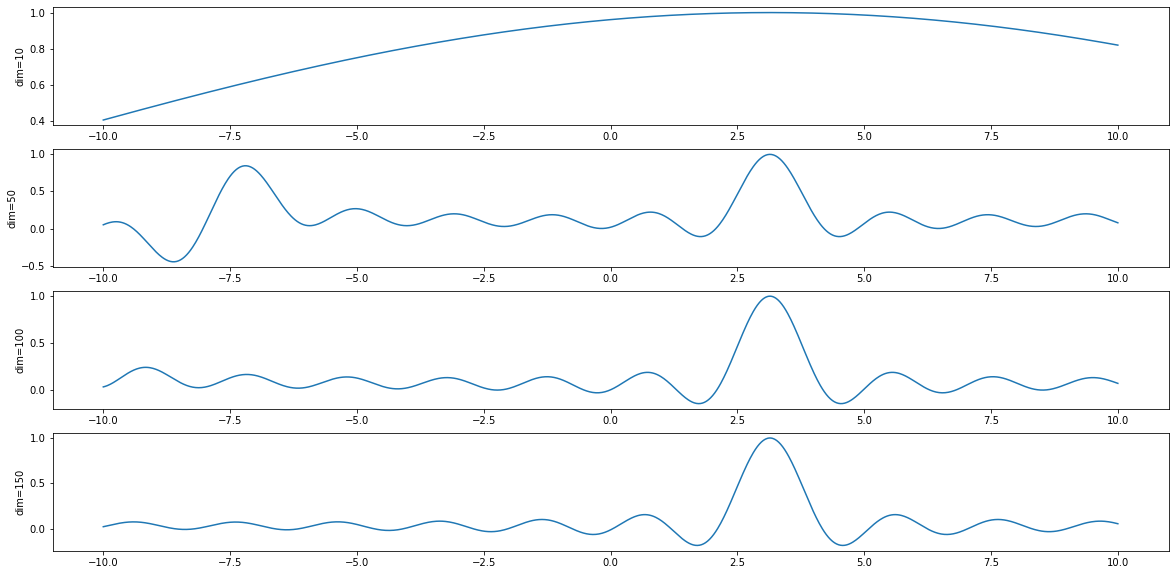

In [23]:
lens = [10, 50, 100, 150]

plt.figure(figsize=(20,10))
for l_idx, l in enumerate(lens):
    ssp_space = sspspace.HexagonalSSPSpace(domain_dim=1, ssp_dim=l, domain_bounds=np.array([[-10,10]]), length_scale=1)
    ssp_xs = ssp_space.encode(np.atleast_2d(xs).T)

    ssp_pi = ssp_space.encode(np.array([[np.pi]]))
    
    sims = np.einsum('nd,sd->ns', ssp_xs, ssp_pi)
    
    plt.subplot(len(lens),1,1+l_idx)
    plt.ylabel(f'dim={l}')
    plt.plot(xs, sims)


ssp shape:  (1000, 41)
1000 41 5 18
1000 41 10 15
1000 41 25 8
1000 41 39 1


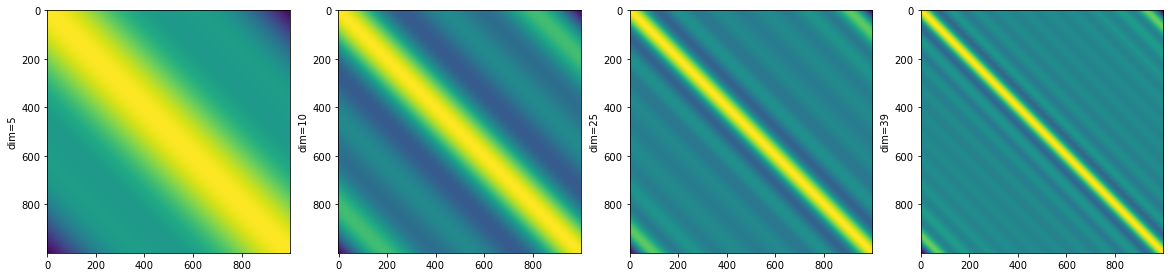

In [52]:
def mask(ssps, break_idx):
    fft_vals = np.fft.fft(ssps, axis=1)
    (rows, cols) = fft_vals.shape
    offset = (cols - break_idx) // 2
    print(rows, cols, break_idx, offset)
    fft_vals[:, -offset:] = 0
    fft_vals[:,:offset] = 0
    
    return np.fft.irfft(fft_vals, axis=1)

ssp_space = sspspace.HexagonalSSPSpace(domain_dim=1, ssp_dim=151, domain_bounds=np.array([[-10,10]]), length_scale=1)
ssp_xs = ssp_space.encode(np.atleast_2d(xs).T)
print('ssp shape: ', ssp_xs.shape)
lens = [5, 10, 25, 39]


plt.figure(figsize=(20,10))
for l_idx, l in enumerate(lens):    
    masked_xs = mask(ssp_xs, l)
    
    sims = np.einsum('nd,sd->ns', masked_xs, masked_xs)
    
    plt.subplot(1, len(lens),1+l_idx)
    plt.imshow(sims)
    plt.ylabel(f'dim={l}')

# Doing the masking with a circulant matrix.

We are doing element-wise multiplication in the fourier domain, should work out to be a multiplication with a circulant matrix of the masking vector in the time domain.

(1000, 41)
(41, 41)
(1000, 41)
(41, 41)
(1000, 41)
(41, 41)
(1000, 41)
(41, 41)


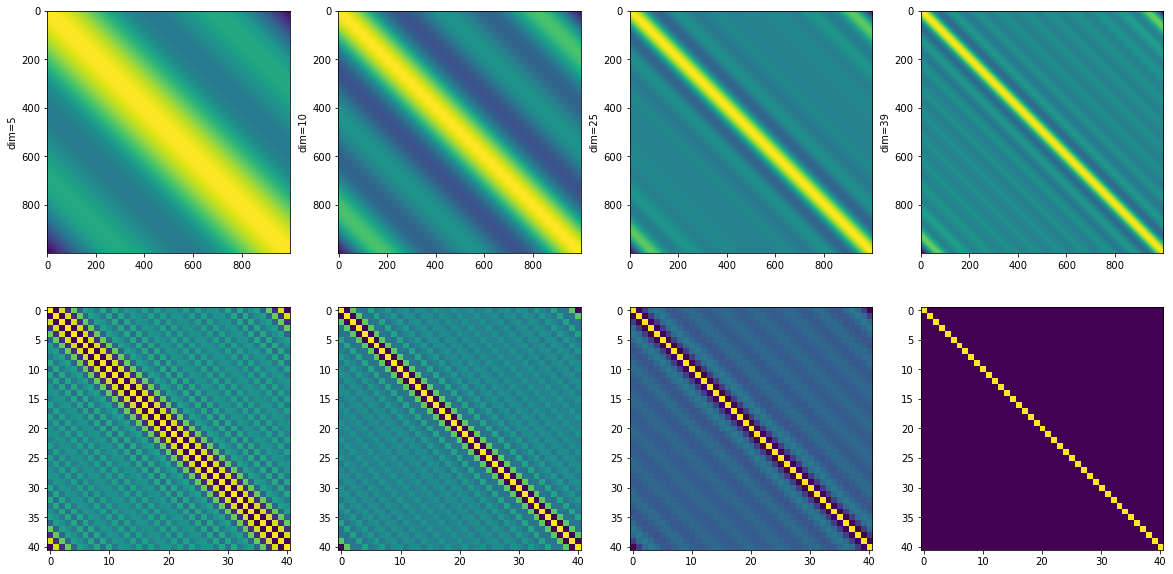

In [77]:
from scipy.linalg import circulant

def make_mask(ssp_dim, break_idx):
    mask = np.ones((ssp_dim,))
    offset = (ssp_dim - break_idx) // 2
    mask[-offset:] = 0
    mask[:offset] = 0
    time_mask = np.fft.irfft(mask, n=ssp_dim)
    
    return circulant(time_mask)


plt.figure(1, figsize=(20,10))
#plt.figure(2, figsize=(20,10))
for l_idx, l in enumerate(lens):    
    xs_mask = make_mask(ssp_xs.shape[1], l)
    print(ssp_xs.shape)
    print(xs_mask.shape)
    
    sims = np.einsum('nd,sd->ns', ssp_xs @ xs_mask, ssp_xs @ xs_mask)
    
    plt.figure(1)
    plt.subplot(2, len(lens),1+l_idx)
    plt.imshow(sims)
    plt.ylabel(f'dim={l}')
    
    plt.subplot(2,len(lens), 1+len(lens)+l_idx)
    plt.imshow(xs_mask)


# What do we take from this?

A couple of things:

- Through simple matrix multiplication we can make a non-stationary kernel
- If we were working in the fourier domain it would be neuromodulation
- We would need to predict the matrix based on the current location in space.

# Does doing this improve non-linear regression?

First step, attempt regression against the nonlinear function.

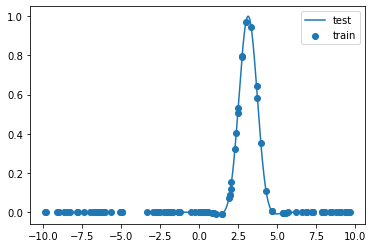

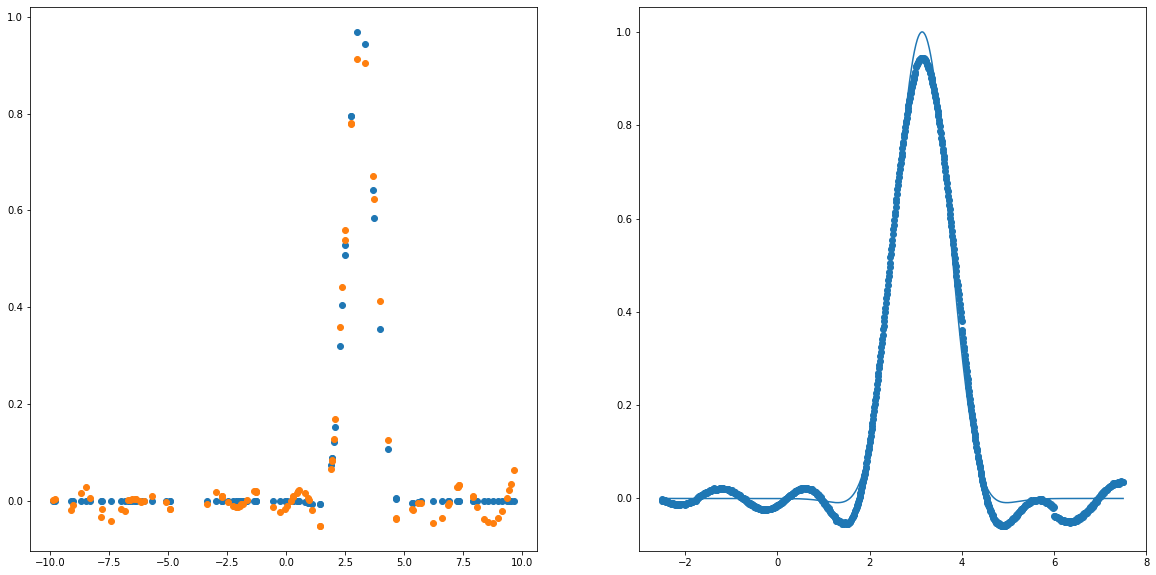

In [86]:
np.random.seed(4)
train_xs = np.random.uniform(low=-10, high=10, size=(100,))
train_ssps = ssp_space.encode(np.atleast_2d(train_xs).T)
train_ys = easom_1d(train_xs).reshape((-1,1))

test_xs = np.linspace(-2.5, 7.5, 1000)
test_ssps = ssp_space.encode(np.atleast_2d(test_xs).T)
test_ys = easom_1d(test_xs).reshape((-1,1))

plt.plot(test_xs, test_ys, label='test')
plt.scatter(train_xs, train_ys, label='train')
plt.legend()

from sklearn.linear_model import LinearRegression

reg = LinearRegression(fit_intercept=False).fit(train_ssps, train_ys)

plt.figure(figsize=(20,10))
plt.subplot(1,2,1)
plt.scatter(train_xs, train_ys)
plt.scatter(train_xs, reg.predict(train_ssps))

plt.subplot(1,2,2)
plt.plot(test_xs, test_ys)
plt.scatter(test_xs, reg.predict(test_ssps))

